In [49]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import statsmodels.api as sm
# set random seed
SEED = 321
np.random.seed(SEED)

sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

In [39]:
# api_url = "https://data.cityofchicago.org/resource/ijzp-q8t2.csv?$query=SELECT%0A%20%20%60id%60%2C%0A%20%20%60case_number%60%2C%0A%20%20%60date%60%2C%0A%20%20%60block%60%2C%0A%20%20%60iucr%60%2C%0A%20%20%60primary_type%60%2C%0A%20%20%60description%60%2C%0A%20%20%60location_description%60%2C%0A%20%20%60arrest%60%2C%0A%20%20%60domestic%60%2C%0A%20%20%60beat%60%2C%0A%20%20%60district%60%2C%0A%20%20%60ward%60%2C%0A%20%20%60community_area%60%2C%0A%20%20%60fbi_code%60%2C%0A%20%20%60x_coordinate%60%2C%0A%20%20%60y_coordinate%60%2C%0A%20%20%60year%60%2C%0A%20%20%60updated_on%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20%60location%60%2C%0A%20%20%60%3A%40computed_region_awaf_s7ux%60%2C%0A%20%20%60%3A%40computed_region_6mkv_f3dw%60%2C%0A%20%20%60%3A%40computed_region_vrxf_vc4k%60%2C%0A%20%20%60%3A%40computed_region_bdys_3d7i%60%2C%0A%20%20%60%3A%40computed_region_43wa_7qmu%60%2C%0A%20%20%60%3A%40computed_region_rpca_8um6%60%2C%0A%20%20%60%3A%40computed_region_d9mm_jgwp%60%2C%0A%20%20%60%3A%40computed_region_d3ds_rm58%60%0AWHERE%20%60date%60%20%3C%20%222023-01-01T15%3A15%3A35%22%20%3A%3A%20floating_timestamp%0AORDER%20BY%20%60date%60%20DESC%20NULL%20FIRST"
fpath = r"C:\Users\ijzp-q8t2.csv"
df = pd.read_csv(fpath)
df.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,:@computed_region_rpca_8um6,:@computed_region_d9mm_jgwp,:@computed_region_d3ds_rm58
0,12938942,JG100778,2023-01-01T15:15:00.000,003XX E 47TH ST,2093,NARCOTICS,FOUND SUSPECT NARCOTICS,RESTAURANT,True,False,...,-87.617558,"\n, \n(41.809368812, -87.617558131)",12.0,4301.0,4.0,162.0,9.0,36.0,24.0,98.0
1,12938945,JG100821,2023-01-01T15:15:00.000,065XX S PEORIA ST,1755,OFFENSE INVOLVING CHILDREN,CHILD ABANDONMENT,APARTMENT,False,True,...,-87.647107,"\n, \n(41.775434922, -87.647106807)",17.0,21559.0,66.0,436.0,32.0,11.0,17.0,202.0
2,12939867,JG101811,2023-01-01T15:10:00.000,002XX E 121ST PL,051A,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,False,...,-87.616411,"\n, \n(41.673554115, -87.616411124)",30.0,21861.0,50.0,504.0,43.0,19.0,10.0,219.0
3,12939039,JG100803,2023-01-01T15:10:00.000,099XX S PAXTON AVE,486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,True,True,...,-87.569442,"\n, \n(41.714693603, -87.569442106)",43.0,21202.0,48.0,252.0,37.0,25.0,19.0,249.0
4,12939335,JG101166,2023-01-01T15:00:00.000,076XX S CICERO AVE,920,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,-87.741529,"\n, \n(41.754592961, -87.741528537)",23.0,4300.0,63.0,318.0,30.0,8.0,13.0,209.0


In [40]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [5]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [42]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [43]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig



In [34]:
# Train the auto_arima model
model = auto_arima(train['id'])

In [50]:
# Assuming 'ts' is your time series data
# Specify the period based on the seasonality you observe in your data
period = 12  # For example, if the data has monthly seasonality
decomp = sm.tsa.seasonal_decompose(ts, period=period)

In [47]:
ts = pd.Series(df['id'].values, index=pd.to_datetime(df['id']))

In [51]:
ts = ts.asfreq('M')

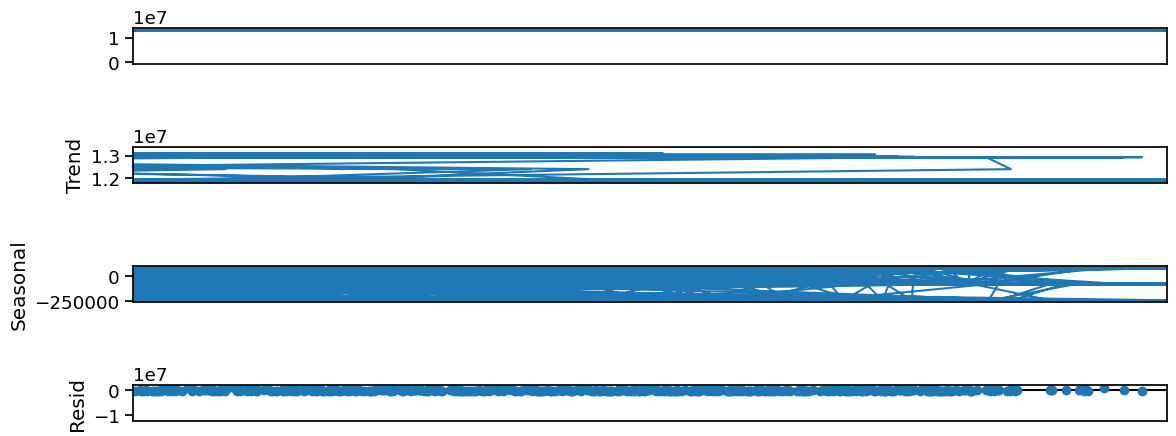

In [54]:
fig = decomp.plot()
fig.set_size_inches(12, 5)